# MultiVI: Integration and joint analysis of paired and unpaired multiomic data
MultiVI is used for the joint analysis of scRNA and scATAC-seq datasets that were jointly profiled (multiomic / paired) and single-modality datasets (only scRNA or only scATAC). MultiVI uses the paired data as an anchor to align and merge the latent spaces learned from each individual modality.

This tutorial walk through how to read multiomic data, create a joint object with paired and unpaired data, set-up and train a MultiVI model, visualize the resulting latent space, and run differential analyses. 

In [5]:
import sys

If True, will install via pypi, else will install from source
stable = False
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and stable:
!pip install --quiet scvi-tools
elif IN_COLAB and not stable:
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@master#egg=scvi-tools[tutorials]

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 243 kB 8.2 MB/s 
     |████████████████████████████████| 916 kB 51.4 MB/s 
     |████████████████████████████████| 209 kB 62.9 MB/s 
     |████████████████████████████████| 678 kB 62.7 MB/s 
     |████████████████████████████████| 636 kB 64.2 MB/s 
     |████████████████████████████████| 118 kB 69.2 MB/s 
     |████████████████████████████████| 272 kB 70.4 MB/s 
     |████████████████████████████████| 829 kB 57.1 MB/s 
     |█████████

## Data acquisition
First we download a sample multiome dataset from 10X. We'll use this throughout this tutorial.
Importantly, MultiVI assumes that there are shared features between the datasets. This is trivial for gene expression datasets, which generally use the same set of genes as features. For ATAC-seq peaks, this is less trivial, and often requires preprocessing steps with other tools to get all datasets to use a shared set of peaks. That can be achieved with tools like SnapATAC, ArchR, and CellRanger in the case of 10X data.

In [11]:
!wget https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_unsorted_10k/pbmc_unsorted_10k_filtered_feature_bc_matrix.tar.gz
!sudo tar -xvf pbmc_unsorted_10k_filtered_feature_bc_matrix.tar.gz
!gunzip -f filtered_feature_bc_matrix/*.gz

--2021-08-20 04:36:45--  https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_unsorted_10k/pbmc_unsorted_10k_filtered_feature_bc_matrix.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.1.173, 104.18.0.173, 2606:4700::6812:ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375260850 (358M) [application/x-tar]
Saving to: ‘pbmc_unsorted_10k_filtered_feature_bc_matrix.tar.gz’

pbmc_unsorted_10k_f 100%[===================>] 357.88M   119MB/s    in 3.0s    

2021-08-20 04:36:48 (119 MB/s) - ‘pbmc_unsorted_10k_filtered_feature_bc_matrix.tar.gz’ saved [375260850/375260850]

filtered_feature_bc_matrix/
filtered_feature_bc_matrix/barcodes.tsv.gz
filtered_feature_bc_matrix/matrix.mtx.gz
filtered_feature_bc_matrix/features.tsv.gz


In [12]:
import scvi
import anndata
import scipy
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

import random
random.seed(420)

## Data Processing
Next, we'll read the data into an Anndata object. We'll then split the data to three datasets, and remove some modality-specific data from parts of the dataset, to demonstrate how MultIVI mixes multimodal and single-modal data.
The data has 12012 cells, we'll use 4004 for each dataset.

In [13]:
## read multiomic data
adata = scvi.data.read_10x_multiome("filtered_feature_bc_matrix")
adata.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [14]:
## split to three datasets by modality (RNA, ATAC, Multiome), and corrupt data 
# by remove some data to create single-modality data
adata_rna = adata[:4004, adata.var.modality == "Gene Expression"].copy()
adata_paired = adata[4004:8008].copy()
adata_atac = adata[8008:, adata.var.modality == "Peaks"].copy()

In [15]:
## We can now use the organizing method from scvi to concatenate these anndata
adata_mvi = scvi.data.organize_multiome_anndatas(adata_paired, adata_rna, adata_atac)

Note that `organize_multiome_anndatas` adds an annotation to the cells to indicate which modality they originate from:

In [16]:
adata_mvi.obs

,batch_id,modality
CCGCTAAAGGGCCATC_paired,1,paired
CCGCTAAAGTCTTGAA_paired,1,paired
CCGCTAAAGTTAGACC_paired,1,paired
CCGCTAAAGTTCCCAC_paired,1,paired
CCGCTAAAGTTTGCGG_paired,1,paired
...,...,...
TTTGTTGGTACGCGCA_accessibility,1,accessibility
TTTGTTGGTATTTGCC_accessibility,1,accessibility
TTTGTTGGTGATTACG_accessibility,1,accessibility
TTTGTTGGTTTCAGGA_accessibility,1,accessibility


**MultiVI requires the features to be ordered, such that genes appear before genomic regions.** This must be enforced by the user.
In this case this is already the case, but it's always good to verify:

In [17]:
adata_mvi = adata_mvi[:, adata_mvi.var["modality"].argsort()].copy()
adata_mvi.var

,ID,modality,chr,start,end
MIR1302-2HG,ENSG00000243485,Gene Expression,chr1,29553,30267
AL391261.2,ENSG00000258847,Gene Expression,chr14,66004522,66004523
FUT8-AS1,ENSG00000276116,Gene Expression,chr14,65412689,65412690
FUT8,ENSG00000033170,Gene Expression,chr14,65410591,65413008
AL355076.2,ENSG00000258760,Gene Expression,chr14,65302679,65318790
...,...,...,...,...,...
chr15:101277030-101277907,chr15:101277030-101277907,Peaks,chr15,101277030,101277907
chr15:101257856-101258771,chr15:101257856-101258771,Peaks,chr15,101257856,101258771
chr15:101251516-101252373,chr15:101251516-101252373,Peaks,chr15,101251516,101252373
chr15:101397608-101398445,chr15:101397608-101398445,Peaks,chr15,101397608,101398445


We also filter features to remove those that appear in fewer than 1% of the cells

In [19]:
print(adata_mvi.shape)
sc.pp.filter_genes(adata_mvi, min_cells=int(adata_mvi.shape[0] * 0.01))
print(adata_mvi.shape)

(12012, 148458)
(12012, 80878)


## Setup and Training MultiVI
We can now set up and train the MultiVI model!
This consists of 2 major steps:

1.   calling `setup_anndata` to organize the object for training. Batch annotations, corresponding to batch effects that the model should correct, are specified at this point. **MultiVI requires the main batch annotation to correspond to the modality of the samples**. Other batch annotation can be specified using `categorical_covariate_keys`.
2.   Training the model.

In [20]:
scvi.data.setup_anndata(adata_mvi, batch_key='modality')

INFO     Using batches from adata.obs["modality"]                                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 12012 cells, 80878 vars, 3        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


**When creating the object, we need to specify how many of the features are genes, and how many are genomic regions.**

In [21]:
mvi = scvi.model.MULTIVI(
    adata_mvi, 
    n_genes=(adata_mvi.var['modality']=='Gene Expression').sum(),
    n_regions=(adata_mvi.var['modality']=='Peaks').sum(),
)
mvi.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/500:  -0%|          | -1/500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:538: TqdmWarning: clamping frac to range [0, 1]
  colour=colour)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:398: LightningDeprecationWarning: One of the returned values {'kl_global', 'n_obs', 'reconstruction_loss_sum', 'kl_local_sum'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  f"One of the returned values {set(extra.keys())} has a `grad_fn`. We will detach it automatically"


Epoch 2/500:   0%|          | 0/500 [00:10<1:24:23, 10.13s/it, loss=1.04e+04, v_num=1]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/callback_hook.py:103: LightningDeprecationWarning: The signature of `Callback.on_train_epoch_end` has changed in v1.3. `outputs` parameter has been removed. Support for the old signature will be removed in v1.5
  "The signature of `Callback.on_train_epoch_end` has changed in v1.3."


Epoch 250/500:  50%|████▉     | 249/500 [41:24<41:34,  9.94s/it, loss=6.72e+03, v_num=1]


In [22]:
## compute the latent space and save it in the anndata object
adata_mvi.obsm["MultiVI_latent"] = mvi.get_latent_representation()

... storing 'modality' as categorical
... storing 'modality' as categorical
... storing 'chr' as categorical


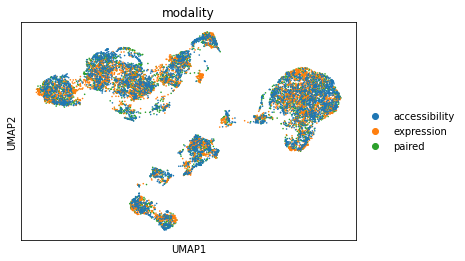

In [23]:
## compute UMAP coordinates and plot the latent space
sc.pp.neighbors(adata_mvi, use_rep="MultiVI_latent")
sc.tl.umap(adata_mvi, min_dist=0.2)
sc.pl.umap(adata_mvi, color='modality')